In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Download price data
ticker = "AAPL"
df = yf.download(ticker, start="2015-01-01", progress=False)

# Keep required columns
df = df[['Close']].copy()
df.dropna(inplace=True)

# Ensure dates are sorted
df = df.sort_index()

df.head()
df.tail()

Price,Close
Ticker,AAPL
Date,
2026-02-09,274.619995
2026-02-10,273.679993
2026-02-11,275.500000
2026-02-12,261.730011
2026-02-13,255.779999


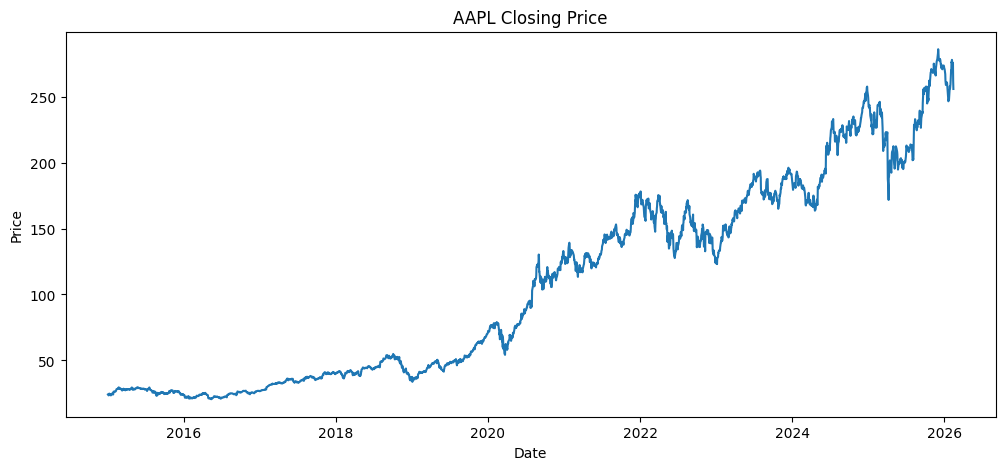

In [2]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close'])
plt.title(f"{ticker} Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

Step 2 

In [3]:
def backtest_strategy(df, signal_col):
    data = df.copy()
    
    # Position uses yesterday's signal (no look-ahead bias)
    data['position'] = data[signal_col].shift(1).fillna(0)
    
    # Daily returns
    data['returns'] = data['Close'].pct_change()
    
    # Strategy returns
    data['strategy_returns'] = data['position'] * data['returns']
    
    # Equity curve
    data['equity'] = (1 + data['strategy_returns']).cumprod()
    
    # Trade count (entries only)
    trades = ((data['position'] == 1) & (data['position'].shift(1) == 0)).sum()
    
    total_return = data['equity'].iloc[-1] - 1
    
    return data, total_return, trades


Step 3: Option A1 — ROC Threshold Strategy

In [24]:
roc_n = 100          # lookback window (days)
roc_threshold = 0.03  # 3% threshold


In [25]:
df['roc'] = df['Close'].pct_change(periods=roc_n)


In [26]:
df['signal'] = (df['roc'] > roc_threshold).astype(int)


Step 4 - Backtest and Report

In [27]:
results, total_return, num_trades = backtest_strategy(df, 'signal')

print(f"Total return: {total_return:.2%}")
print(f"Number of trades: {num_trades}")

Total return: 201.84%
Number of trades: 53


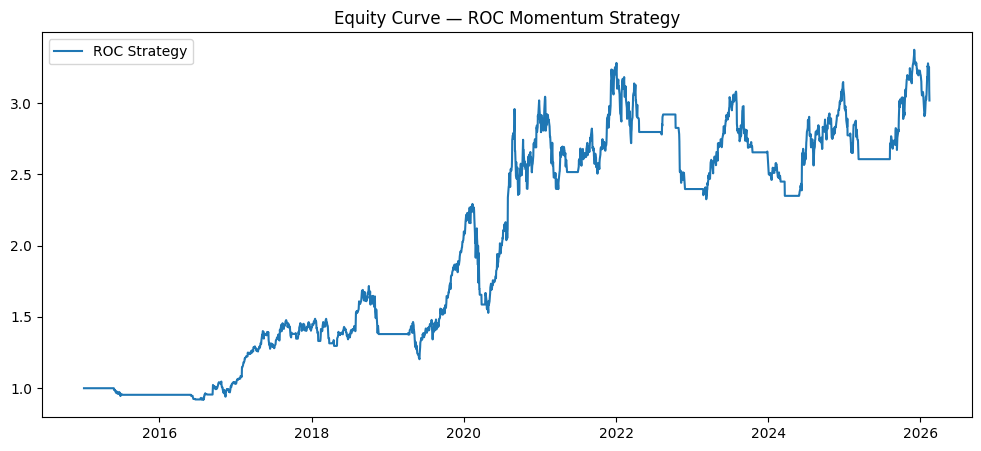

In [28]:
plt.figure(figsize=(12,5))
plt.plot(results.index, results['equity'], label='ROC Strategy')
plt.title("Equity Curve — ROC Momentum Strategy")
plt.legend()
plt.show()

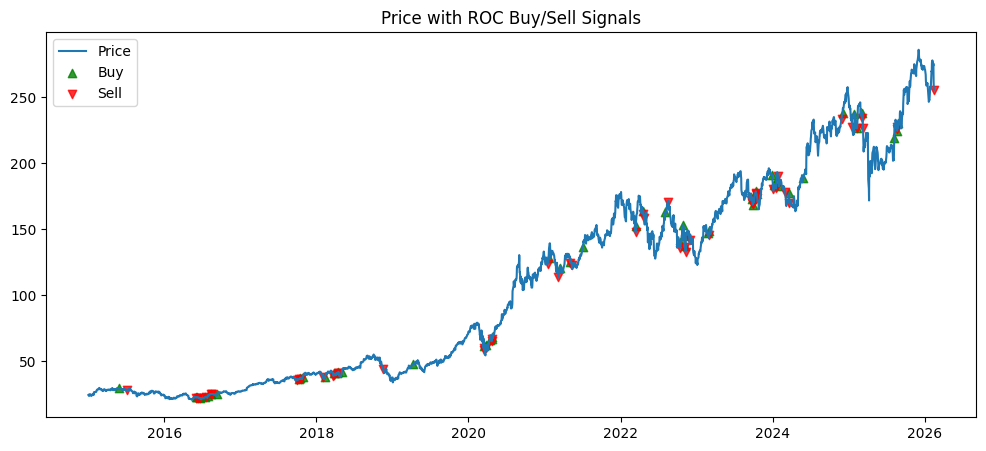

In [29]:
plt.figure(figsize=(12,5))
plt.plot(results.index, results['Close'], label='Price')

buy_signals = results[(results['signal'] == 1) & (results['signal'].shift(1) == 0)]
plt.scatter(buy_signals.index, buy_signals['Close'], 
            marker='^', color='green', label='Buy', alpha=0.8)

sell_signals = results[(results['signal'] == 0) & (results['signal'].shift(1) == 1)]
plt.scatter(sell_signals.index, sell_signals['Close'], marker = 'v', color = 'red', label ='Sell', alpha = 0.8)

plt.title("Price with ROC Buy/Sell Signals")
plt.legend()
plt.show()

ROC (Rate of Change) measures how much the closing price has moved over the past n trading days; here we use a 10‑day lookback and go long when the price has risen by more than +3% over that window. The strategy enters when ROC exceeds the threshold and exits to cash when ROC falls back below it (sell marker when the signal goes 1→0). Momentum may persist due to investor underreaction, herding, and slow diffusion of information, which can reinforce trends for a while. A limitation is vulnerability to sharp reversals and whipsaws when momentum is choppy.
